In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Sources consulted include:
- Lecture materials
- Matplotlib, Seaborn, Sklearn and Keras documentation
- In particular, for building the ROC curve: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-download-auto-examples-model-selection-plot-roc-py
- Sources consulted for understanding the structure of VGG16: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c and https://builtin.com/machine-learning/vgg16

First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

In [ ]:
""""
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = '/content/drive/MyDrive/Deep Learning/lung_colon_image_set'
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/Deep Learning/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep Learning/labels120.npy",tr_labels)

"""


'"\nimport os\nimport pandas as pd\nimport numpy as np\nfrom PIL import Image\nimport matplotlib.pyplot as plt\n\n# Replace these paths with the actual paths to your dataset folders\ndata_dir = \'/content/drive/MyDrive/Deep Learning/lung_colon_image_set\'\nfilepaths = []\nimage_data = []\nlabels = []\n\n\nfolds = os.listdir(data_dir)\n\nfor fold in folds:\n    foldpath = os.path.join(data_dir, fold)\n    flist = os.listdir(foldpath)\n\n    for f in flist:\n        f_path = os.path.join(foldpath , f)\n        filelist = os.listdir(f_path)\n\n        for file in filelist:\n            fpath = os.path.join(f_path , file)\n            try:\n              # Open the image using PIL (or you can use OpenCV) within a \'with\' statement\n              with Image.open(fpath) as image:\n                if image is not None:\n                  # Resize images\n                  im = image.resize((120,120), Image.LANCZOS)\n                  # Append image and label to respective lists\n            

Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [2]:
# Collect imports in one place
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import logging
logging.getLogger('tensorflow').disabled = True
import seaborn as sns
import tensorflow as tf
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.models import Model
from keras.optimizers import Adam

In [3]:
file_dir = "/content/drive/MyDrive/Deep Learning/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma' ... 'Colon adenocarcinoma'
 'Colon adenocarcinoma' 'Colon adenocarcinoma']


In [4]:
print(data.shape)
print(labels.shape)

(25000, 120, 120, 3)
(25000,)


# Preprocessing and EDA (Exploratory Data Analysis)


In [4]:
# Save unique labels
unique_labels = np.unique(labels)
print(unique_labels)
# 5 classes

['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']


## Visualizing Class Distribution

In [6]:
# Count how many samples in each class
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))
# Each class contains 5000 samples

{'Colon Benign Tissue': 5000,
 'Colon adenocarcinoma': 5000,
 'Lung Benign Tissue': 5000,
 'Lung Squamous Cell Carcinoma': 5000,
 'Lung adenocarcinoma': 5000}

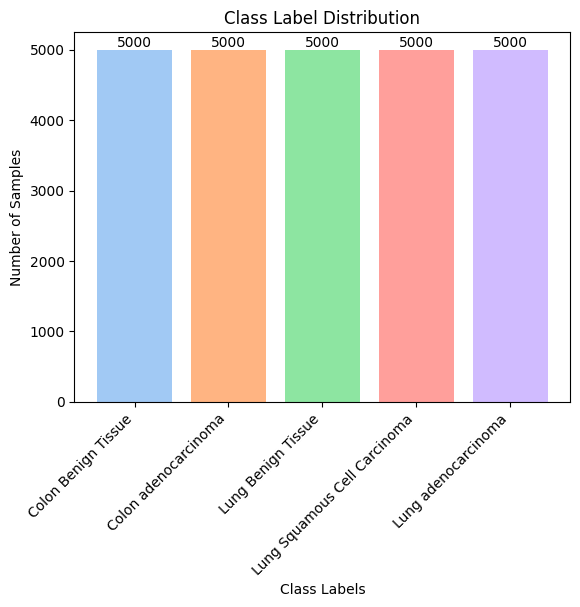

In [7]:
# Same as above
class_labels, class_counts = np.unique(labels, return_counts=True)

# Barplot
plt.bar(class_labels, class_counts, color=sns.color_palette("pastel"))
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution')
plt.xticks(range(len(class_labels)), unique_labels, rotation=45, ha='right')

# Display the counts
for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

## Visualizing Sample Images

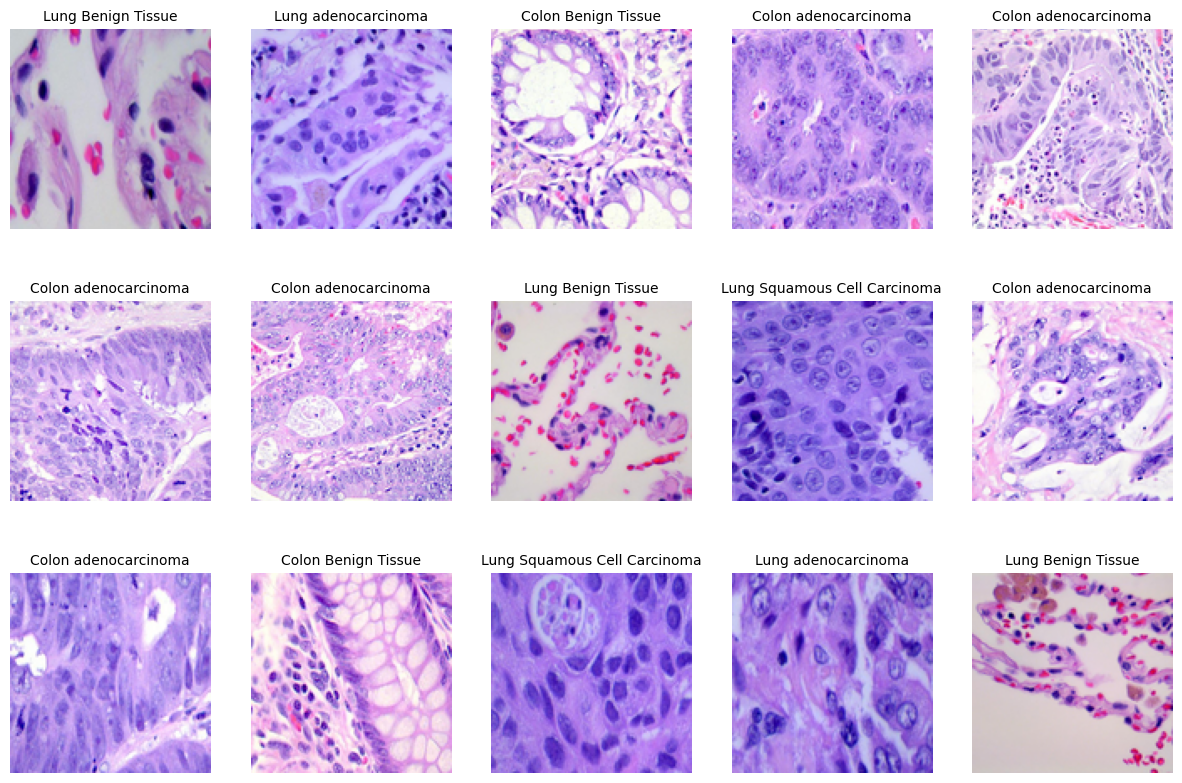

In [8]:
# Plot figure and adjust size
plt.figure(figsize=(15, 10))

# Randomly select 15 different samples from the entire dataset
random_samples = np.random.choice(len(data), 15, replace=False)

for i, sample in enumerate(random_samples, 1):
  # 3 by 5 subplot
  plt.subplot(3, 5, i)
  # Display image
  plt.imshow(data[sample])
  # Convert to string to display text
  labels_str = str(labels[sample])
  # Plot labels as text
  plt.title(labels_str, fontsize=10)
  # Do not plot ticks
  plt.axis('off')

plt.show()

## Converting the Target Values to the One-Hot-Encoded Format

In [5]:
# One-hot encode labels
labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels)

In [10]:
labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

##Train-Test-Val Split

In [6]:
# Create train, validation, and test sets by performing stratified train-test splits with proportions of 60%
# for training, 20% for validation, and 20% for the test set, using a random seed of 42 for reproducibility.

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the train set to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [12]:
# Print shape of train, val, test sets
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(16000, 120, 120, 3)
(4000, 120, 120, 3)
(5000, 120, 120, 3)
(16000, 5)
(4000, 5)
(5000, 5)


In [7]:
# Set to float
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [3]:
## LOSS-ACC GRAPHS
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	plt.legend(['training', 'validation'])

  # plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.tight_layout()
	plt.show()


In [4]:
# Define function to plot confusion matrix
def plot_confusion_matrix(model, X, y_true, class_labels):
    y_pred = model.predict(X).argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)
    columns = range(len(class_labels))
    conf_matrix = pd.DataFrame(cm, index=class_labels, columns=columns)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [5]:
# Define ROC plot
def plot_roc(best_model, X, y_true, class_labels):
    # Predict probabilities using best_model saved
    y_score = best_model.predict(X)

    # Number of classes
    n_classes = len(class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
             color='deeppink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f"Macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
             color='navy', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve class {i} (AUC = {roc_auc[i]:.2f})")

    # Plot chance level
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance level')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# Baseline Model

In [11]:
# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu', input_shape = X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Add a Flatten layer to the model
model.add(layers.Flatten())

# Add two Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Output layer
model.add(layers.Dense(5, activation='softmax'))


In [18]:
# Check requirements
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Save best model with checkpoint (given the computational cost, saving the model will save time)
filepath = "/content/drive/MyDrive/Deep Learning/best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', verbose=1)


In [14]:
# Train the model (add checkpoint)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/10
499/500 [============================>.] - ETA: 0s - loss: 7.1843 - accuracy: 0.3748
Epoch 1: val_loss improved from inf to 0.96093, saving model to /content/drive/MyDrive/Deep Learning/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 30s 47ms/step - loss: 7.1717 - accuracy: 0.3753 - val_loss: 0.9609 - val_accuracy: 0.5612
Epoch 2/10
499/500 [============================>.] - ETA: 0s - loss: 0.9425 - accuracy: 0.5643
Epoch 2: val_loss improved from 0.96093 to 0.82028, saving model to /content/drive/MyDrive/Deep Learning/best_model.h5
500/500 [==============================] - 18s 35ms/step - loss: 0.9420 - accuracy: 0.5646 - val_loss: 0.8203 - val_accuracy: 0.6423
Epoch 3/10
499/500 [============================>.] - ETA: 0s - loss: 0.8289 - accuracy: 0.6261
Epoch 3: val_loss improved from 0.82028 to 0.75664, saving model to /content/drive/MyDrive/Deep Learning/best_model.h5
500/500 [==============================] - 18s 37ms/step - loss: 0.8290 - accuracy: 0.6258 - val_loss: 0.7566 - val_accuracy: 0.6752
Epoch 4/10
499/500 [============================>.] - ETA: 0s - loss: 0.7805 - accuracy: 0.6425
Epoch 4: val_loss did not improve from 0.75664
500/500 [===================

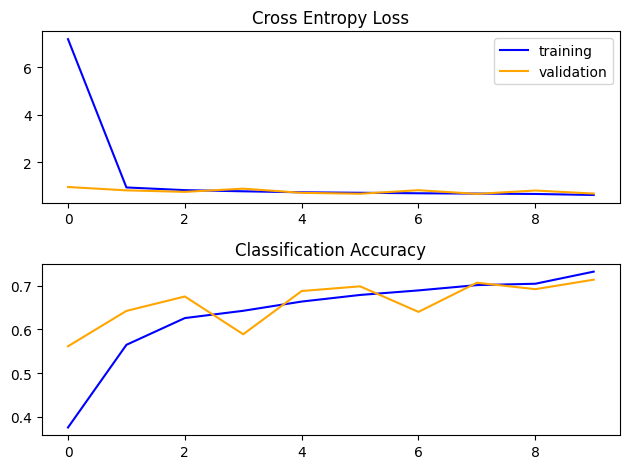

In [15]:
# Plot training and validation losses and accuracies on the training and validation set throughout epochs
summarize_diagnostics(history)


In [9]:
# Load model
best_model = load_model("/content/drive/MyDrive/Deep Learning/best_model.h5")

In [12]:
# Evaluate the model on the validation set
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

125/125 [==============================] - 3s 9ms/step - loss: 0.6717 - accuracy: 0.7067
Validation Loss: 0.6716898679733276
Validation Accuracy: 0.7067499756813049


In [13]:
# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

157/157 [==============================] - 3s 20ms/step - loss: 0.6404 - accuracy: 0.7208
Test Loss: 0.6403656005859375
Test Accuracy: 0.72079998254776


In [14]:
# Predict probabilities
y_val_prob = best_model.predict(X_val)
y_test_prob = best_model.predict(X_test)

# Assign class labels
y_val_pred = (y_val_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

157/157 [==============================] - 1s 6ms/step


In [15]:
# Performance measures for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71       800
           1       0.71      0.51      0.60       800
           2       0.97      0.82      0.89       800
           3       0.74      0.61      0.67       800
           4       0.62      0.64      0.63       800

   micro avg       0.72      0.68      0.70      4000
   macro avg       0.74      0.68      0.70      4000
weighted avg       0.74      0.68      0.70      4000
 samples avg       0.68      0.68      0.68      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Performance measures for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.63      0.83      0.72      1000
           1       0.73      0.51      0.60      1000
           2       0.98      0.81      0.89      1000
           3       0.75      0.64      0.69      1000
           4       0.66      0.68      0.67      1000

   micro avg       0.74      0.69      0.71      5000
   macro avg       0.75      0.69      0.71      5000
weighted avg       0.75      0.69      0.71      5000
 samples avg       0.69      0.69      0.69      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


125/125 [==============================] - 1s 5ms/step


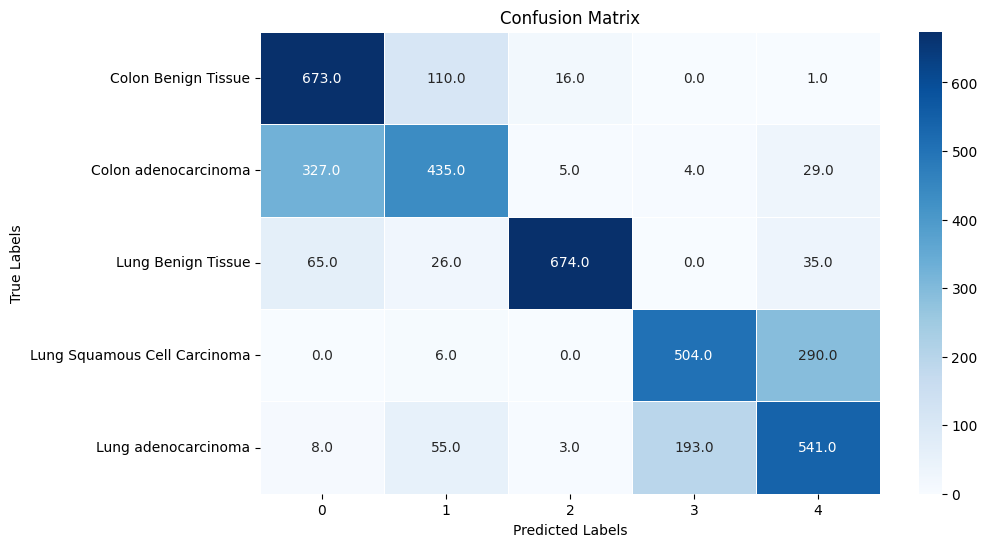

In [17]:
# Validation Confusion Matrix
class_labels = unique_labels
plot_confusion_matrix(best_model, X_val, y_val.argmax(axis=1), class_labels)

157/157 [==============================] - 1s 7ms/step


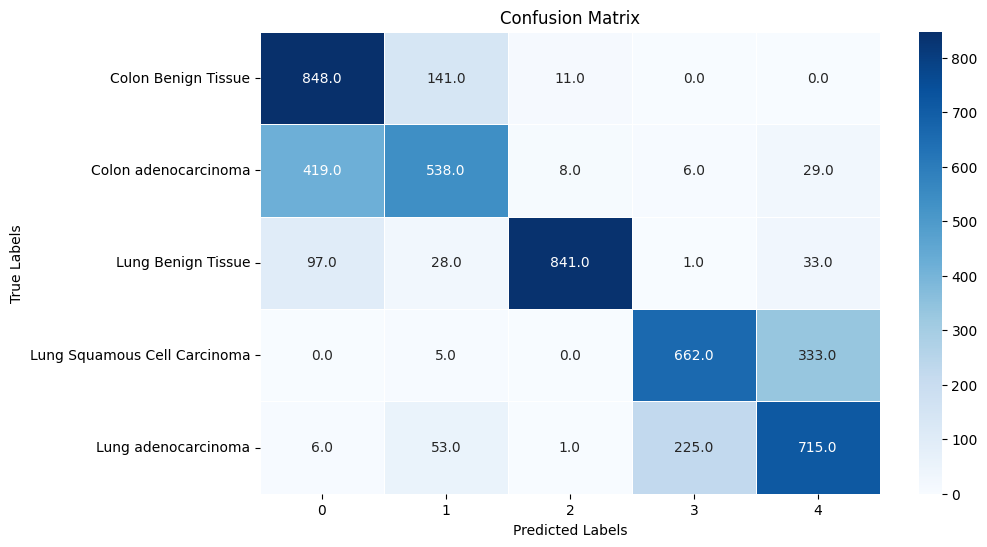

In [18]:
# Test Confusion Matrix
plot_confusion_matrix(best_model, X_test, y_test.argmax(axis=1), class_labels)

125/125 [==============================] - 4s 11ms/step


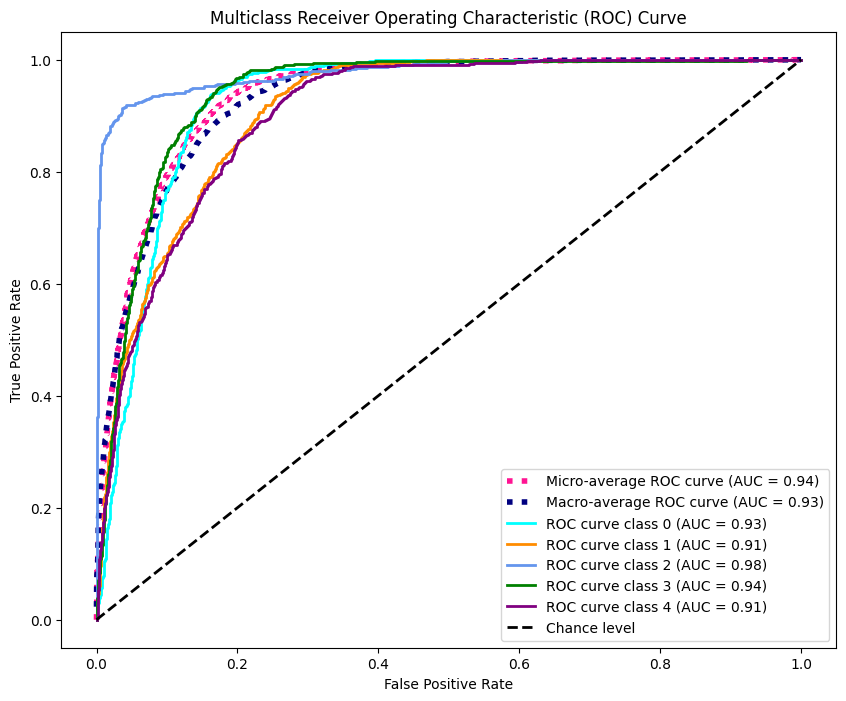

In [10]:
# Plot ROC for validation set
class_labels = unique_labels
plot_roc(best_model, X_val, y_val, class_labels)

157/157 [==============================] - 2s 12ms/step


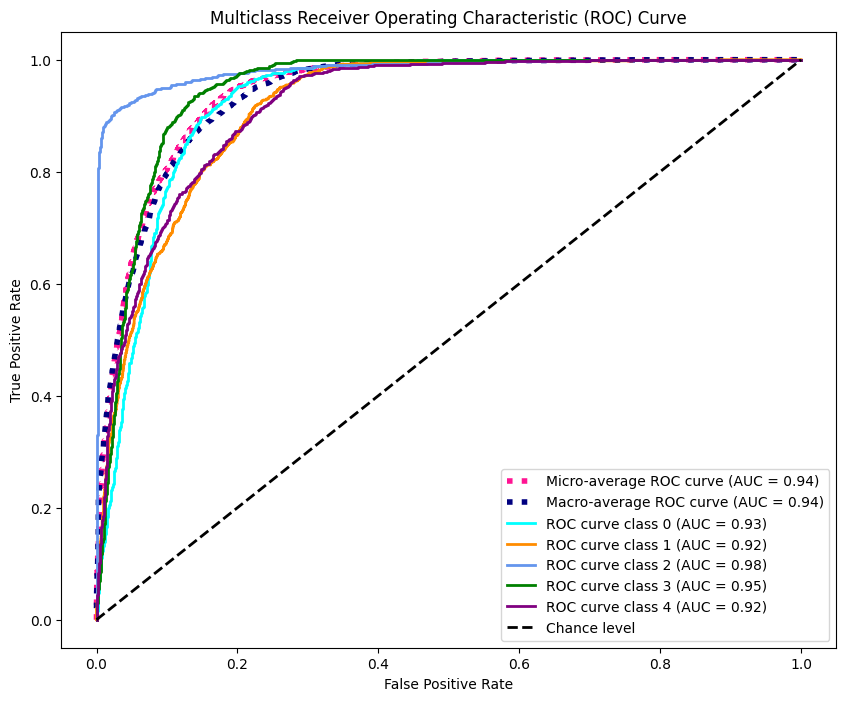

In [11]:
# Plot ROC for test set
plot_roc(best_model, X_test, y_test, class_labels)


# Enhanced Model - Part 1


In [6]:
# Load data
file_dir = "/content/drive/MyDrive/Deep Learning/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma' ... 'Colon adenocarcinoma'
 'Colon adenocarcinoma' 'Colon adenocarcinoma']


In [9]:
print(data.shape)
print(labels.shape)

(25000, 120, 120, 3)
(25000,)


In [7]:
# Save unique_labels
unique_labels = np.unique(labels)
print(unique_labels)

['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']


In [8]:
# One-hot encode labels
labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels)

In [9]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the train set to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [10]:
# Set to float
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# In part one changes were made to the architecture of the network, in particular depth was added.
# 4 blocks of convolutional and MaxPooling layers are followed by two dense layers.
# The filter size increases after each block.
# This structure was inspired by the VGG16 model.

# Create a sequential model
model2 = Sequential()

# Block 1
model2.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=X_train.shape[1:]))
model2.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Block 2
model2.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model2.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Block 3
model2.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model2.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Block 4
model2.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model2.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model2.add(layers.Flatten())

# Fully connected layers
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))

# Output layer
model2.add(layers.Dense(5, activation='softmax'))


In [10]:
# Model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                   

In [15]:
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Save best model with checkpoint
model2_filepath = "/content/drive/MyDrive/Deep Learning/best_model2.h5"
model2_checkpoint = ModelCheckpoint(model2_filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', verbose=1)


In [17]:
# Train the model (add checkpoint)
model2_history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[model2_checkpoint])

Epoch 1/10
499/500 [============================>.] - ETA: 0s - loss: 0.8375 - accuracy: 0.6291
Epoch 1: val_loss improved from inf to 0.45771, saving model to /content/drive/MyDrive/Deep Learning/best_model2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 39s 57ms/step - loss: 0.8363 - accuracy: 0.6298 - val_loss: 0.4577 - val_accuracy: 0.8160
Epoch 2/10
499/500 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8811
Epoch 2: val_loss improved from 0.45771 to 0.37638, saving model to /content/drive/MyDrive/Deep Learning/best_model2.h5
500/500 [==============================] - 23s 47ms/step - loss: 0.3028 - accuracy: 0.8811 - val_loss: 0.3764 - val_accuracy: 0.8403
Epoch 3/10
499/500 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9289
Epoch 3: val_loss improved from 0.37638 to 0.20602, saving model to /content/drive/MyDrive/Deep Learning/best_model2.h5
500/500 [==============================] - 23s 46ms/step - loss: 0.1962 - accuracy: 0.9289 - val_loss: 0.2060 - val_accuracy: 0.9210
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9476
Epoch 4: val_loss improved from 0.20602 to 0.15066, saving model to /cont

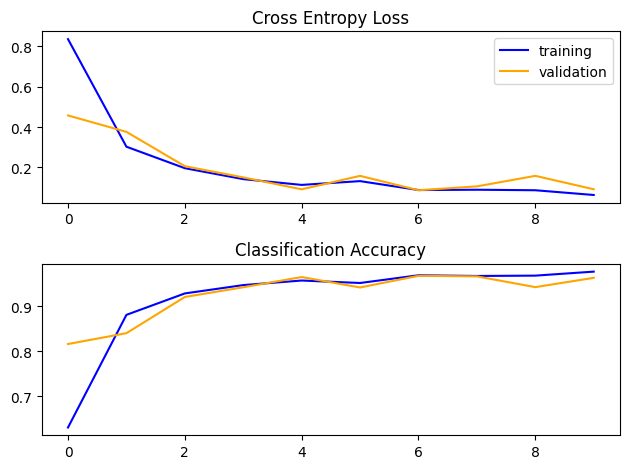

In [18]:
summarize_diagnostics(model2_history)

In [11]:
# Load model
best_model2 = load_model("/content/drive/MyDrive/Deep Learning/best_model2.h5")


In [12]:
# Evaluate the model on the validation set
val_loss, val_acc = best_model2.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

125/125 [==============================] - 5s 8ms/step - loss: 0.0868 - accuracy: 0.9682
Validation Loss: 0.08684766292572021
Validation Accuracy: 0.9682499766349792


In [13]:
# Evaluate the model on the test set
test_loss, test_acc = best_model2.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

157/157 [==============================] - 3s 15ms/step - loss: 0.0736 - accuracy: 0.9706
Test Loss: 0.07355912774801254
Test Accuracy: 0.9706000089645386


In [14]:
# Predict probabilities
y_val_prob = best_model2.predict(X_val)
y_test_prob = best_model2.predict(X_test)

# Assign class labels
y_val_pred = (y_val_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

157/157 [==============================] - 1s 6ms/step


In [15]:
# Performance measures for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       800
           1       0.98      1.00      0.99       800
           2       0.99      1.00      0.99       800
           3       0.97      0.91      0.94       800
           4       0.92      0.95      0.93       800

   micro avg       0.97      0.97      0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000
 samples avg       0.97      0.97      0.97      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Performance measures for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       0.99      1.00      0.99      1000
           2       0.99      1.00      1.00      1000
           3       0.96      0.92      0.94      1000
           4       0.92      0.94      0.93      1000

   micro avg       0.97      0.97      0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000
 samples avg       0.97      0.97      0.97      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Enhanced model - Part 2

In [11]:
# In this second part, the model's architecture was perfected by running multiple tests and examining the differences.
# The architecture was simplified in the initial 2 convolution and MaxPooling blocks.
# The number of neurons was reduced in the fully connected layers.
# Further tweaking of hyperparameters: L2 regularization, dropout, learning rate, early stopping, number of epochs,
# and patience argument.

# Create a sequential model
model2_2 = Sequential()

# Block 1
model2_2.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=X_train.shape[1:], kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.MaxPooling2D((2, 2)))

# Block 2
model2_2.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.MaxPooling2D((2, 2)))

# Block 3
model2_2.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.MaxPooling2D((2, 2)))

# Block 4
model2_2.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model2_2.add(layers.Flatten())

# Fully connected layers
model2_2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.Dropout(0.2))
model2_2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model2_2.add(layers.Dropout(0.2))

# Output layer
model2_2.add(layers.Dense(5, activation='softmax'))

optimize = optimizers.Adam(learning_rate=0.0001)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [12]:
# Model summary
model2_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 128)      

In [12]:
# Compile the model
model2_2.compile(optimizer=optimize, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Save best model with checkpoint
model2_2_filepath = "/content/drive/MyDrive/Deep Learning/best_model2_2.h5"
model2_2_checkpoint = ModelCheckpoint(model2_2_filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', verbose=1)


In [14]:
# Train the model (add checkpoint)
model2_2_history = model2_2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop, model2_2_checkpoint])

Epoch 1/50
499/500 [============================>.] - ETA: 0s - loss: 1.9543 - accuracy: 0.4580
Epoch 1: val_loss improved from inf to 1.30080, saving model to /content/drive/MyDrive/Deep Learning/best_model2_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 29s 36ms/step - loss: 1.9536 - accuracy: 0.4581 - val_loss: 1.3008 - val_accuracy: 0.6660
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 1.3652 - accuracy: 0.6104
Epoch 2: val_loss improved from 1.30080 to 1.03638, saving model to /content/drive/MyDrive/Deep Learning/best_model2_2.h5
500/500 [==============================] - 15s 30ms/step - loss: 1.3652 - accuracy: 0.6104 - val_loss: 1.0364 - val_accuracy: 0.8145
Epoch 3/50
499/500 [============================>.] - ETA: 0s - loss: 1.0731 - accuracy: 0.7700
Epoch 3: val_loss improved from 1.03638 to 0.83297, saving model to /content/drive/MyDrive/Deep Learning/best_model2_2.h5
500/500 [==============================] - 16s 32ms/step - loss: 1.0725 - accuracy: 0.7702 - val_loss: 0.8330 - val_accuracy: 0.8790
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.8567
Epoch 4: val_loss did not improve from 0.83297
500/500 [=============

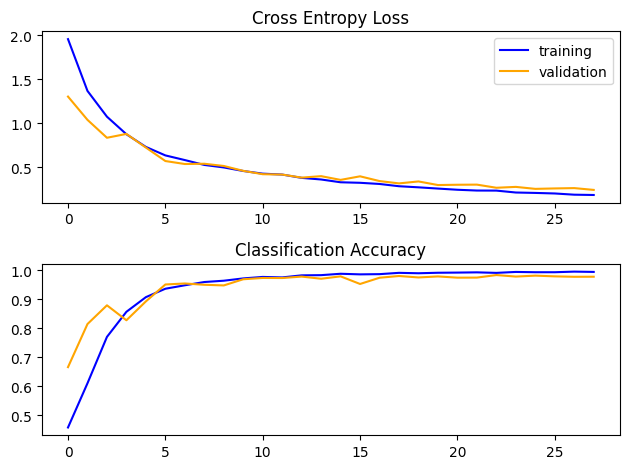

In [15]:
summarize_diagnostics(model2_2_history)

In [12]:
# Load model
best_model2_2 = load_model("/content/drive/MyDrive/Deep Learning/best_model2_2.h5")

In [13]:
# Evaluate the model on the validation set
val_loss, val_acc = best_model2_2.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

125/125 [==============================] - 4s 8ms/step - loss: 0.2650 - accuracy: 0.9833
Validation Loss: 0.2650158107280731
Validation Accuracy: 0.9832500219345093


In [14]:
# Evaluate the model on the test set
test_loss, test_acc = best_model2_2.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

157/157 [==============================] - 2s 8ms/step - loss: 0.2501 - accuracy: 0.9846
Test Loss: 0.2500597834587097
Test Accuracy: 0.9846000075340271


In [15]:
# Predict probabilities
y_val_prob = best_model2_2.predict(X_val)
y_test_prob = best_model2_2.predict(X_test)

# Assign class labels
y_val_pred = (y_val_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

157/157 [==============================] - 1s 5ms/step


In [16]:
# Performance measures for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       800
           1       1.00      0.99      0.99       800
           2       1.00      1.00      1.00       800
           3       0.96      0.97      0.97       800
           4       0.97      0.96      0.96       800

   micro avg       0.98      0.98      0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000
 samples avg       0.98      0.98      0.98      4000



In [18]:
# Performance measures for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       1.00      0.99      0.99      1000
           2       1.00      1.00      1.00      1000
           3       0.96      0.97      0.97      1000
           4       0.97      0.96      0.97      1000

   micro avg       0.98      0.98      0.98      5000
   macro avg       0.99      0.98      0.98      5000
weighted avg       0.99      0.98      0.98      5000
 samples avg       0.98      0.98      0.98      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


125/125 [==============================] - 1s 7ms/step


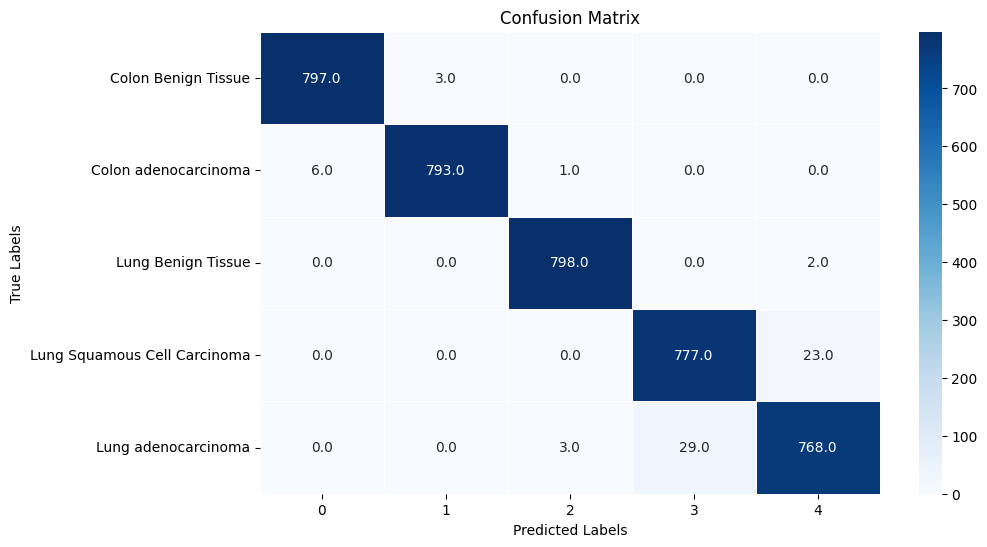

In [17]:
# Validation Confusion Matrix
class_labels = unique_labels
plot_confusion_matrix(best_model2_2, X_val, y_val.argmax(axis=1), class_labels)

157/157 [==============================] - 1s 5ms/step


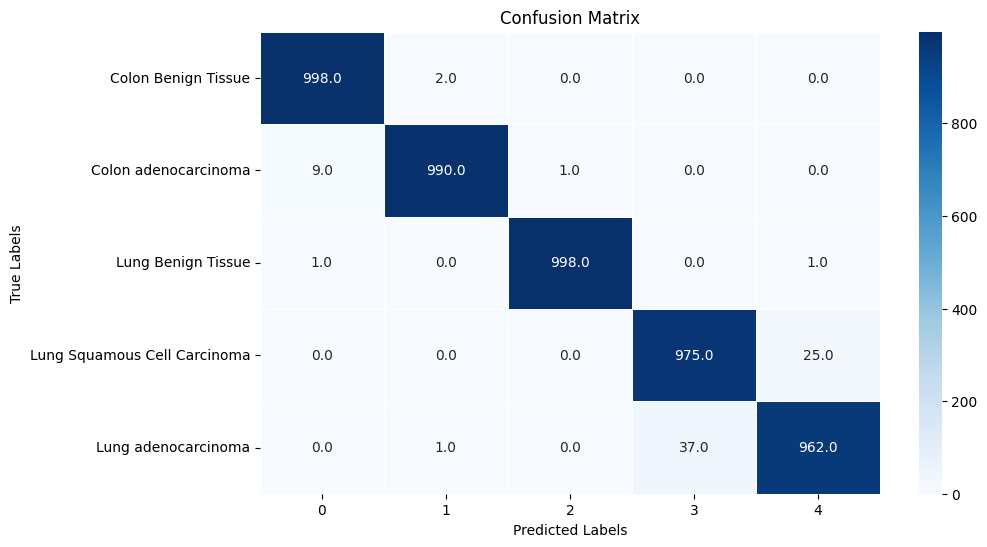

In [19]:
# Test Confusion Matrix
plot_confusion_matrix(best_model2_2, X_test, y_test.argmax(axis=1), class_labels)

125/125 [==============================] - 2s 9ms/step


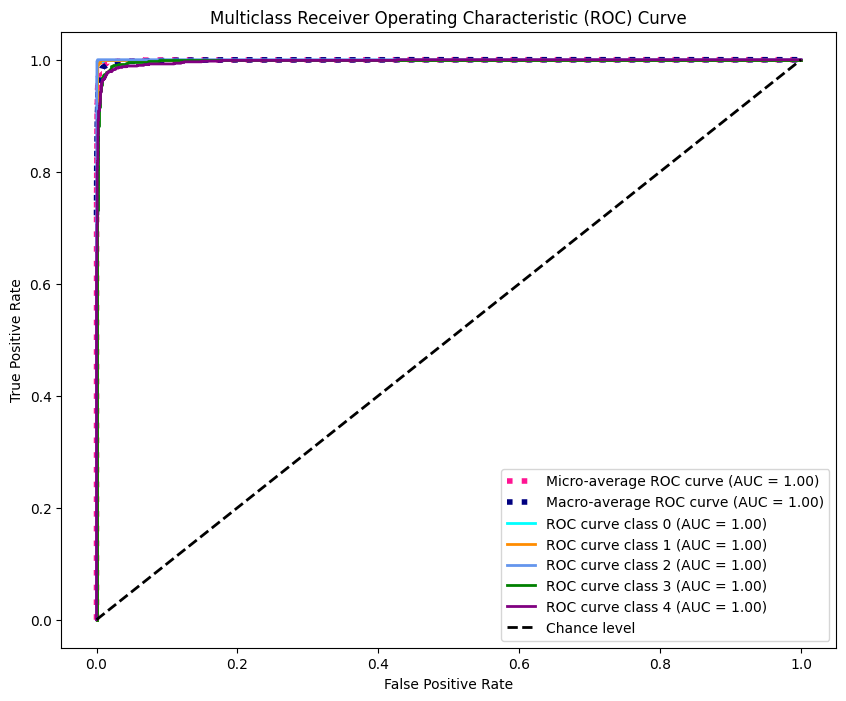

In [13]:
# Plot ROC for validation set
class_labels = unique_labels
plot_roc(best_model2_2, X_val, y_val, class_labels)

157/157 [==============================] - 6s 32ms/step


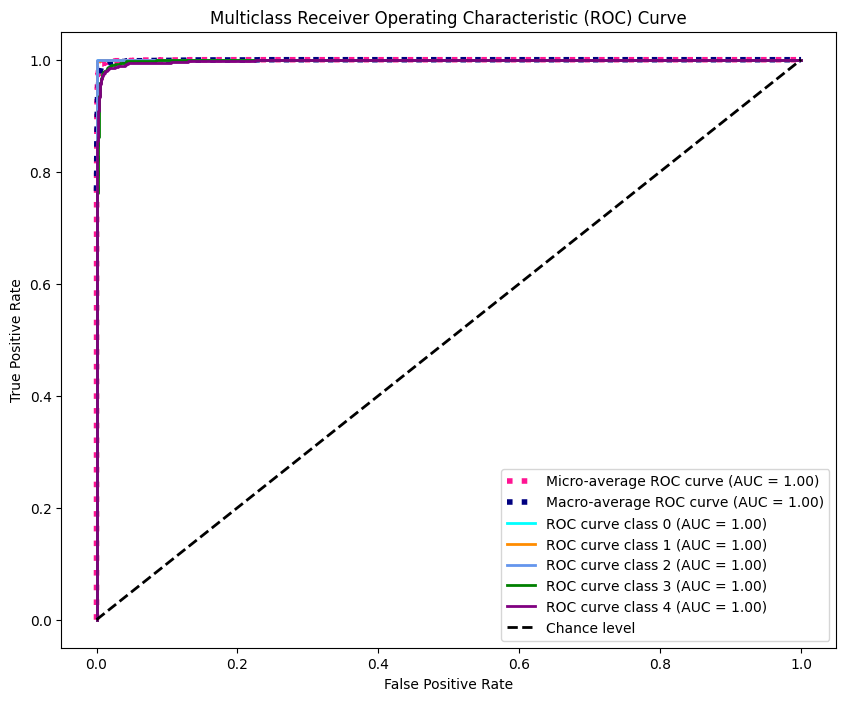

In [15]:
# Plot ROC for test set
plot_roc(best_model2_2, X_test, y_test, class_labels)

# Transfer Learning Model


In [8]:
## Loading and pre-processing steps
# Load data
file_dir = "/content/drive/MyDrive/Deep Learning/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)

# Save unique_labels
unique_labels = np.unique(labels)

# One-hot encode labels
labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Further split the train set to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Set to float
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


In [7]:
# Load the VGG16 model
VGG_model = VGG16(include_top=False, input_shape=(120, 120, 3))

# Freeze the layers (mark as non-trainable)
for layer in VGG_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [8]:
# Flatten
flatten = layers.Flatten()(VGG_model.layers[-1].output)

# Fully connected layers
fc_layer_1 = layers.Dense(128, activation='relu')(flatten)
fc_layer_2 = layers.Dense(64, activation='relu')(fc_layer_1)

# Output layer
output = layers.Dense(5, activation='softmax')(fc_layer_2)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Summarize
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [9]:
# Create the model
tf_model = Model(inputs=VGG_model.input, outputs=output)

# Compile the model
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
tf_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [10]:
# Save best model with checkpoint
tf_model_filepath = "/content/drive/MyDrive/Deep Learning/best_tf_model.h5"
tf_model_checkpoint = ModelCheckpoint(tf_model_filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', verbose=1)


In [11]:
# Train the model
history_tf = tf_model.fit(X_train, y_train, epochs=30, batch_size=32,
                                validation_data=(X_val, y_val),
                                callbacks=[early_stop, tf_model_checkpoint])

Epoch 1/30
498/500 [============================>.] - ETA: 0s - loss: 0.3385 - accuracy: 0.9156
Epoch 1: val_loss improved from inf to 0.14510, saving model to /content/drive/MyDrive/Deep Learning/best_tf_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 22s 33ms/step - loss: 0.3376 - accuracy: 0.9158 - val_loss: 0.1451 - val_accuracy: 0.9475
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9713
Epoch 2: val_loss improved from 0.14510 to 0.10220, saving model to /content/drive/MyDrive/Deep Learning/best_tf_model.h5
500/500 [==============================] - 10s 21ms/step - loss: 0.0792 - accuracy: 0.9713 - val_loss: 0.1022 - val_accuracy: 0.9663
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9753
Epoch 3: val_loss did not improve from 0.10220
500/500 [==============================] - 10s 21ms/step - loss: 0.0711 - accuracy: 0.9753 - val_loss: 0.1123 - val_accuracy: 0.9607
Epoch 4/30
499/500 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9772
Epoch 4: val_loss did not improve from 0.10220
500/500 [==============================] - 10s 20ms/step - loss: 0.0702 - accuracy: 0.9772 - val_

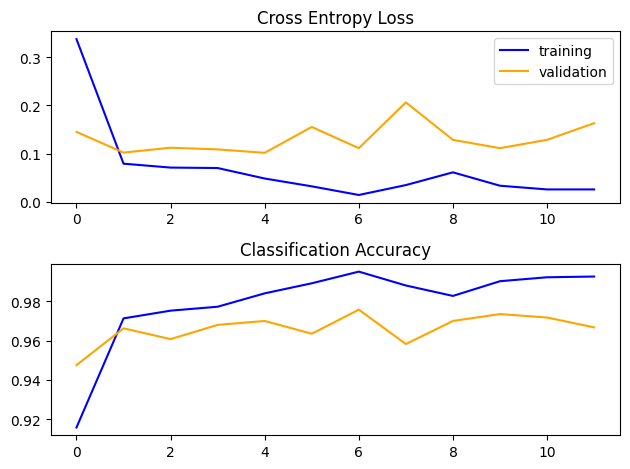

In [12]:
summarize_diagnostics(history_tf)

In [9]:
# Load tf model
best_tf = load_model("/content/drive/MyDrive/Deep Learning/best_tf_model.h5")

In [10]:
# Evaluate the model on the validation set
val_loss, val_acc = best_tf.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

125/125 [==============================] - 9s 41ms/step - loss: 0.1018 - accuracy: 0.9700
Validation Loss: 0.1017545759677887
Validation Accuracy: 0.9700000286102295


In [11]:
# Evaluate the model on the test set
test_loss, test_acc = best_tf.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

157/157 [==============================] - 8s 47ms/step - loss: 0.1005 - accuracy: 0.9726
Test Loss: 0.10047996044158936
Test Accuracy: 0.972599983215332


In [12]:
# Predict probabilities
y_val_prob = best_tf.predict(X_val)
y_test_prob = best_tf.predict(X_test)

# Assign predicted class
y_val_pred = (y_val_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

157/157 [==============================] - 7s 41ms/step


In [13]:
# Performance measures for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       800
           1       0.99      0.98      0.98       800
           2       0.99      1.00      0.99       800
           3       0.93      0.96      0.95       800
           4       0.95      0.93      0.94       800

   micro avg       0.97      0.97      0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000
 samples avg       0.97      0.97      0.97      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Performance measures for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.97      0.98      1000
           2       0.99      1.00      0.99      1000
           3       0.94      0.98      0.96      1000
           4       0.97      0.93      0.95      1000

   micro avg       0.97      0.97      0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000
 samples avg       0.97      0.97      0.97      5000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


125/125 [==============================] - 5s 41ms/step


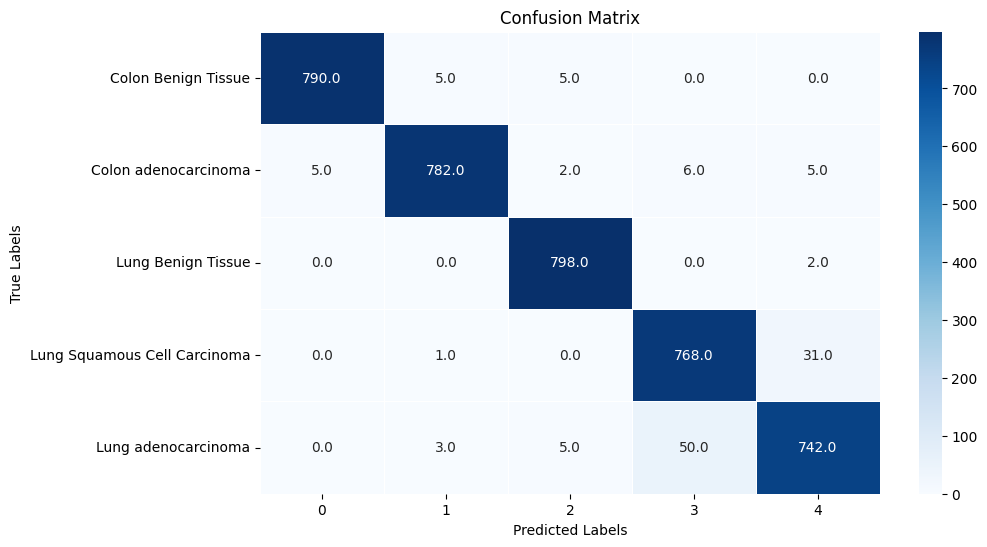

In [15]:
# Validation Confusion Matrix
class_labels = unique_labels
plot_confusion_matrix(best_tf, X_val, y_val.argmax(axis=1), class_labels)

157/157 [==============================] - 7s 42ms/step


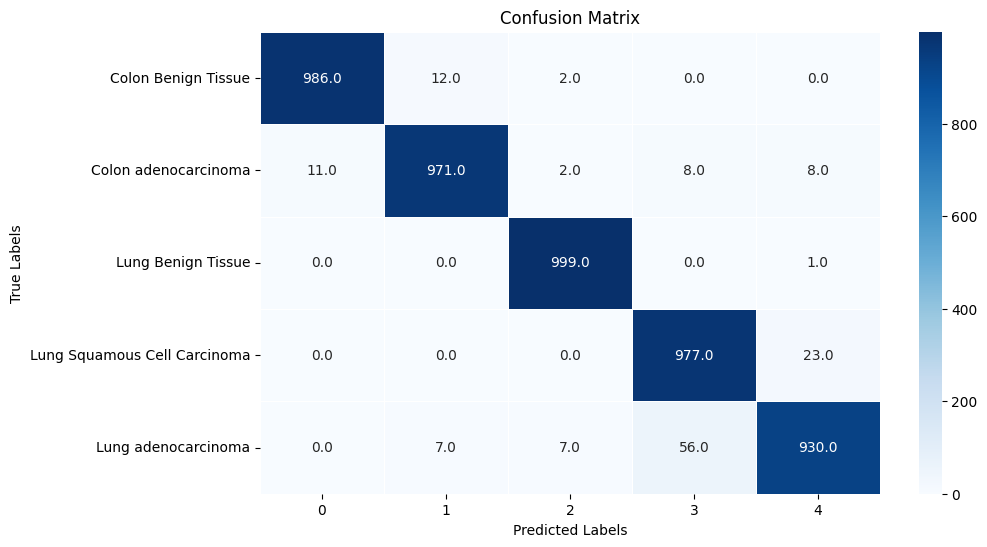

In [16]:
# Test Confusion Matrix
plot_confusion_matrix(best_tf, X_test, y_test.argmax(axis=1), class_labels)

125/125 [==============================] - 5s 42ms/step


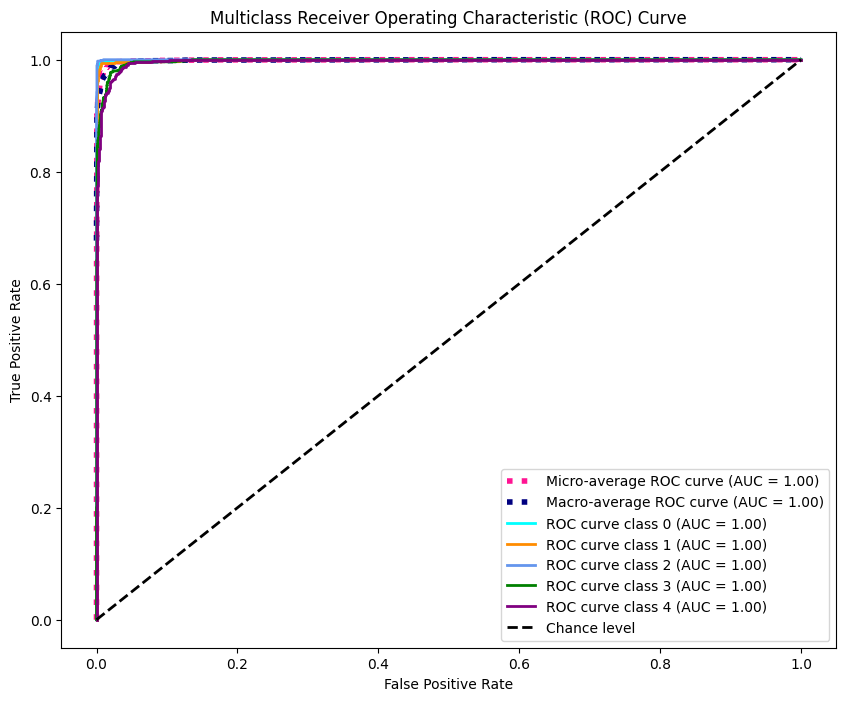

In [17]:
# Plot ROC for validation set
class_labels = unique_labels
plot_roc(best_tf, X_val, y_val, class_labels)

157/157 [==============================] - 6s 41ms/step


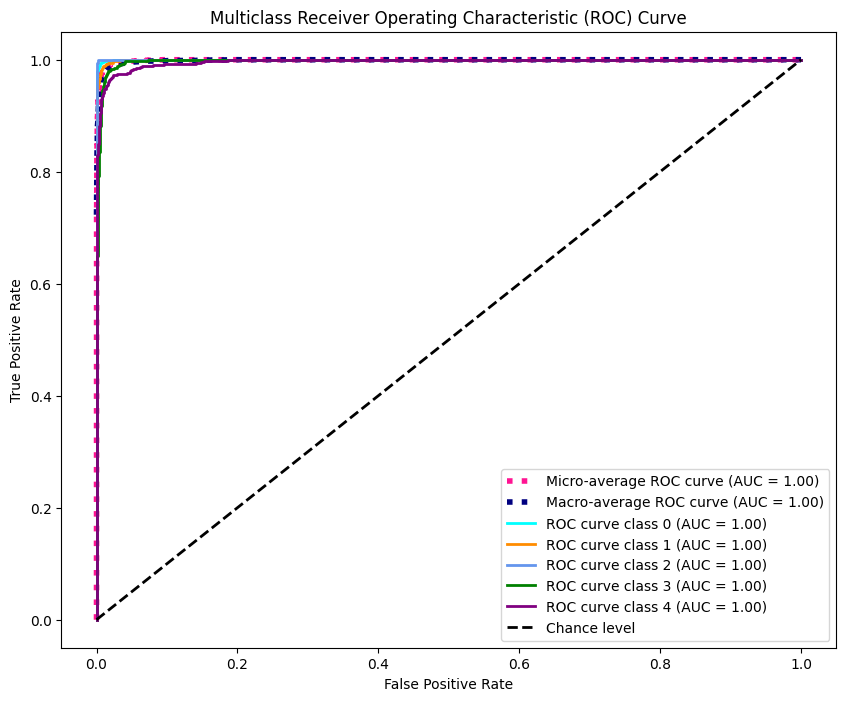

In [18]:
# Plot ROC for test set
plot_roc(best_tf, X_test, y_test, class_labels)